In [1]:
N_VAL = 100
RANDOM_STATE = 0

In [2]:
import pandas as pd

train_data = pd.read_csv("data/train.csv")
display(train_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Data exploration

In [3]:
train_data["Survived"].value_counts(dropna=False)

Survived
0    549
1    342
Name: count, dtype: int64

In [4]:
train_data["Embarked"].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [5]:
train_data = train_data.drop(
    columns=[
        "PassengerId",  # completely irrelevant
        "Ticket",       # very unlikely to be relevant
        "Name",         # may be relevant (ethnicity, etc.), but hard to work with
        "Cabin",        # may be relevant (ship location), but harder to work with
    ]
)

train_data["Sex"] = train_data["Sex"].apply(lambda x: int(x == "male"))

# The default order (S, C, Q) is the same as the traveling order
train_data["Embarked"] = train_data["Embarked"].fillna("S")
_embarked_values = {k: i for i, k in enumerate(train_data["Embarked"].unique())}
train_data["Embarked"] = train_data["Embarked"].apply(_embarked_values.get)

display(train_data)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,0
3,1,1,0,35.0,1,0,53.1000,0
4,0,3,1,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0
887,1,1,0,19.0,0,0,30.0000,0
888,0,3,0,NaN,1,2,23.4500,0
889,1,1,1,26.0,0,0,30.0000,1


In [6]:
train_data.isna().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [7]:
val_data = train_data.sample(N_VAL, random_state=RANDOM_STATE).sort_index()
train_data = train_data[~train_data.index.isin(val_data.index)]

display(train_data)
display(val_data)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,0
3,1,1,0,35.0,1,0,53.1000,0
4,0,3,1,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
884,0,3,1,25.0,0,0,7.0500,0
885,0,3,0,39.0,0,5,29.1250,2
886,0,2,1,27.0,0,0,13.0000,0
888,0,3,0,NaN,1,2,23.4500,0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
8,1,3,0,27.0,0,2,11.1333,0
14,0,3,0,14.0,0,0,7.8542,0
27,0,1,1,19.0,3,2,263.0000,0
30,0,1,1,40.0,0,0,27.7208,1
31,1,1,0,NaN,1,0,146.5208,1
...,...,...,...,...,...,...,...,...
877,0,3,1,19.0,0,0,7.8958,0
880,1,2,0,25.0,0,1,26.0000,0
883,0,2,1,28.0,0,0,10.5000,0
887,1,1,0,19.0,0,0,30.0000,0


## Feature importance exploration

In [8]:
import numpy as np
from scipy.stats import entropy

display(float(entropy(train_data["Survived"])))

def discretize(col: pd.Series, bins=5) -> pd.Series:
    bins = np.asarray([col.quantile(q) for q in np.linspace(0, 1, bins + 1)])[:-1]
    return col.apply(lambda x: int((x > bins).sum()))

def entropy_gain(x: str, y: str = "Survived") -> float:
    data = train_data[[x, y]].copy()
    ent_y = entropy(data[y])
    if data[x].dtype == float:
        data[x] = discretize(data[x])
    grouped_x = data.groupby(x, dropna=False)["Survived"]
    grouped_y = grouped_x.apply(entropy)
    grouped_count = grouped_x.count()
    return ent_y - (grouped_count * grouped_y).sum() / grouped_count.sum()

entropy_gains = {x: entropy_gain(x) for x in train_data.columns if x != "Survived"}
for x, gain in sorted(entropy_gains.items(), key=lambda kv: kv[1])[::-1]:
    print(f"{x:<9}:  {gain:>10.5f}")

5.700443573390687

Age      :     1.80644
Fare     :     1.76757
Pclass   :     1.06643
SibSp    :     0.93691
Sex      :     0.87797
Parch    :     0.78569
Embarked :     0.77284


In [9]:
from sklearn.feature_selection import f_classif, mutual_info_classif

f_values, mi_values = {}, {}
for x in train_data.columns:
    if x == "Survived":
        continue
    x_col = train_data[x]
    if x_col.dtype == float:
        x_col = discretize(x_col)
    f_values[x] = f_classif(x_col.values.reshape(-1, 1), train_data['Survived'])[0][0]
    mi_values[x] = mutual_info_classif(x_col.values.reshape(-1, 1), train_data['Survived'])[0]

print("ANOVA f-values")
for x, f_value in sorted(f_values.items(), key=lambda kv: kv[1])[::-1]:
    print(f"{x:<9}:  {f_value:>10.5f}")

print("\nMutual information")
for x, mi_value in sorted(mi_values.items(), key=lambda kv: kv[1])[::-1]:
    print(f"{x:<9}:  {mi_value:>10.5f}")

ANOVA f-values
Sex      :   325.08799
Pclass   :    89.49943
Fare     :    75.76808
Embarked :    10.13624
Parch    :     5.02766
SibSp    :     0.58714
Age      :     0.33033

Mutual information
Sex      :     0.14849
Pclass   :     0.05595
Fare     :     0.04122
SibSp    :     0.03848
Parch    :     0.01588
Embarked :     0.00674
Age      :     0.00000


# Fit LightGBM

# Feature selection

In [10]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

all_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
cat_features = ["Pclass", "Sex", "Embarked"]


def fit_lgbm_model(
    features: list[str],
    train_data = train_data,
    eval_data = val_data,
    model_params: dict = {},
    fit_params: dict = {},
    threshold: float = 0.5,
    verbose: bool = True,
) -> tuple[lgb.LGBMClassifier, dict]:
    X_train, X_eval = train_data[features], eval_data[features]
    y_train, y_eval = train_data["Survived"], eval_data["Survived"]

    clf = lgb.LGBMClassifier(
        verbose=-1,
        random_state=RANDOM_STATE,
        **model_params
    )
    clf.fit(
        X_train,
        y_train,
        categorical_feature=list(set(cat_features) & set(features)),
        **fit_params
    )

    p_train = clf.predict_proba(X_train)[:, 1]
    p_eval = clf.predict_proba(X_eval)[:, 1]
    yhat_train = p_train >= threshold
    yhat_eval = p_eval >= threshold

    metrics = dict(
        train_acc=float((y_train == yhat_train).mean()),
        val_acc=float((y_eval == yhat_eval).mean()),
        train_auc=float(roc_auc_score(y_train, p_train)),
        val_auc=float(roc_auc_score(y_eval, p_eval)),
    )
    if verbose:
        print({k: round(v, 5) for k, v in metrics.items()})
    return clf, metrics

auc_values = {}
for f in all_features:
    _, metrics = fit_lgbm_model([f], verbose=False)
    auc_values[f] = (metrics["train_auc"], metrics["val_auc"])

print("AUC from single-feature LGBM fit")
for f, (auc_train, auc_val) in sorted(auc_values.items(), key=lambda kv: kv[1][0])[::-1]:
    print(f"{f:<9}:  {auc_train:>10.5f} train, {auc_val:>10.5f} val")

AUC from single-feature LGBM fit
Fare     :     0.81004 train,    0.76907 val
Sex      :     0.76593 train,    0.77581 val
Pclass   :     0.67050 train,    0.75418 val
Age      :     0.66682 train,    0.56018 val
SibSp    :     0.59440 train,    0.62138 val
Embarked :     0.57310 train,    0.58038 val
Parch    :     0.56551 train,    0.57568 val


### Use all features

In [11]:
fit_lgbm_model(all_features);

{'train_acc': 0.95449, 'val_acc': 0.84, 'train_auc': 0.99152, 'val_auc': 0.86597}


### Try removing a bunch of features

In [12]:
features = all_features.copy()
features.remove("Embarked")

fit_lgbm_model(features);

{'train_acc': 0.94817, 'val_acc': 0.84, 'train_auc': 0.99048, 'val_auc': 0.87882}


In [13]:
features = all_features.copy()
features.remove("Embarked")
features.remove("Parch")  # Parch, SibSp, Age

fit_lgbm_model(features);

{'train_acc': 0.94437, 'val_acc': 0.84, 'train_auc': 0.9897, 'val_auc': 0.87271}


In [14]:
features = all_features.copy()
features.remove("Embarked")
features.remove("Age")

fit_lgbm_model(features);

{'train_acc': 0.88496, 'val_acc': 0.8, 'train_auc': 0.93997, 'val_auc': 0.87944}


## Hyperparameter tuning

In [15]:
features = all_features.copy()
features.remove("Embarked")

model_params = dict(
    learning_rate=0.1,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=10,
    colsample_bytree=0.9,
)
clf, metrics = fit_lgbm_model(features, model_params=model_params, threshold=0.48)

{'train_acc': 0.88243, 'val_acc': 0.87, 'train_auc': 0.92896, 'val_auc': 0.93125}


# Feature importances

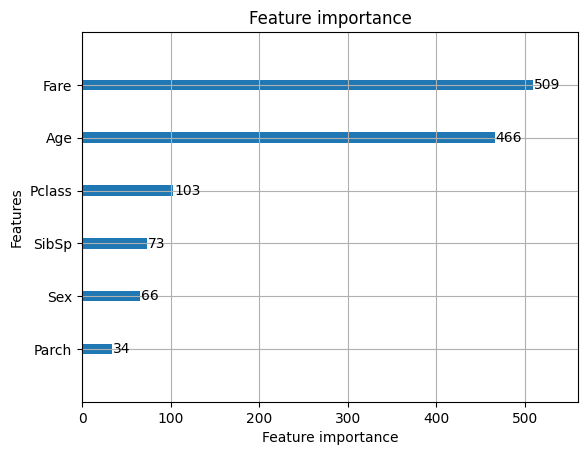

In [16]:
lgb.plot_importance(clf);

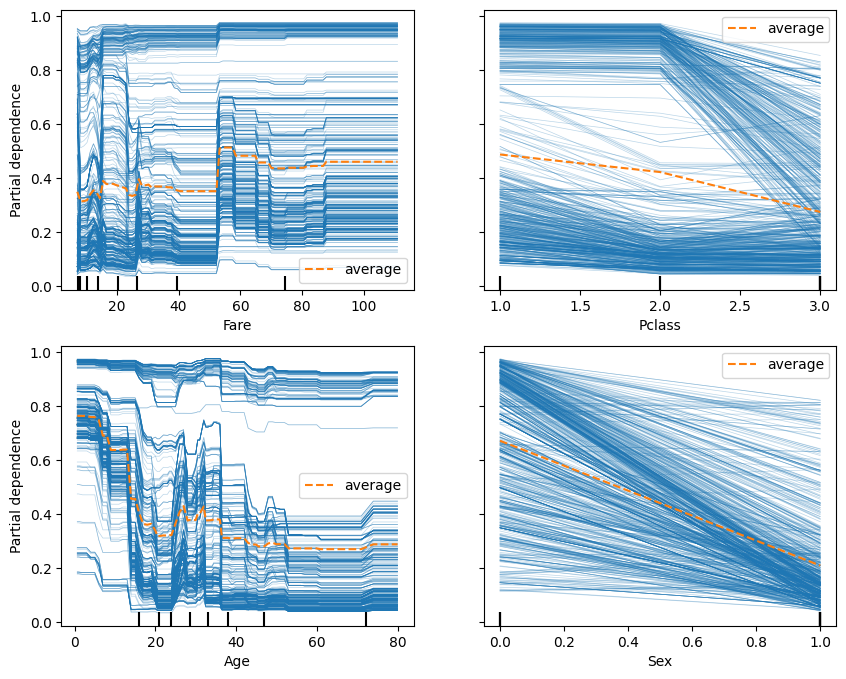

In [17]:
# See https://scikit-learn.org/stable/modules/partial_dependence.html
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

_, axs = plt.subplots(2, 2, figsize=(10, 8))
PartialDependenceDisplay.from_estimator(
    clf,
    train_data[features],
    ["Fare", "Pclass", "Age", "Sex"],
    kind="both",  # average + individual
    ax=axs,
);